In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


In [549]:
import time
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from scipy.optimize import minimize
from sklearn.cluster import KMeans

from tqdm.notebook import trange, tqdm

In [664]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib notebook
np.set_printoptions(precision=4, linewidth=500, threshold=500, suppress=True)

In [4]:
from numpy import kron, eye as I, exp, trace as tr, diag
from numpy.linalg import inv, eigh, det, solve
from numpy.random import randn

In [773]:
from utils import vec, mat, get_chain_graph, get_random_graph, matrix_derivative_numerical, mat_pow, diagi, vector_derivative_numerical, filter_functions

In [798]:
l = [1, 2, 3, 4]
l.pop()

4

In [796]:
mat(diag(H @ H), like=J)

array([[0.4244, 0.2318, 0.2246, ..., 0.2246, 0.2318, 0.4244],
       [0.2316, 0.114 , 0.1295, ..., 0.1295, 0.114 , 0.2316],
       [0.2248, 0.1297, 0.1265, ..., 0.1265, 0.1297, 0.2248],
       ...,
       [0.2248, 0.1297, 0.1265, ..., 0.1265, 0.1297, 0.2248],
       [0.2316, 0.114 , 0.1295, ..., 0.1295, 0.114 , 0.2316],
       [0.4244, 0.2318, 0.2246, ..., 0.2246, 0.2318, 0.4244]])

In [797]:
(UN ** 2) @ (G ** 2) @ (UT.T ** 2)

array([[0.4244, 0.2318, 0.2246, ..., 0.2246, 0.2318, 0.4244],
       [0.2316, 0.114 , 0.1295, ..., 0.1295, 0.114 , 0.2316],
       [0.2248, 0.1297, 0.1265, ..., 0.1265, 0.1297, 0.2248],
       ...,
       [0.2248, 0.1297, 0.1265, ..., 0.1265, 0.1297, 0.2248],
       [0.2316, 0.114 , 0.1295, ..., 0.1295, 0.114 , 0.2316],
       [0.4244, 0.2318, 0.2246, ..., 0.2246, 0.2318, 0.4244]])

In [781]:
def get_params(T, N, gamma, beta=None, Q=None, function='exponential', random_graph=False, seed=True, p=0.5):
    
    if seed:
        np.random.seed(1)
    
    Y = np.random.normal(size=(N, T)) 
    S = np.random.choice([0, 1], p=[1 - p, p], replace=True, size=(N, T))
    S_ = 1 - S
    Y = Y * S

    K = np.exp(-(np.linspace(0, 3, T)[:, None] - np.linspace(0, 3, T)[None, :]) ** 2) + 1e-4 * I(T)
    
    if random_graph:
        AT, LT = get_random_graph(T)
        AN, LN = get_random_graph(N)
        
    else:
        AT, LT = get_chain_graph(T)
        AN, LN = get_chain_graph(N)

    lamLT, UT = eigh(LT)
    lamLN, UN = eigh(LN)
    lamK, V = eigh(K)
    
    if beta is None:
#         beta = 5 / max([max(lamLN), max(lamLT)])
        beta = {'inverse': 10, 'exponential': 1.5, 'ReLu': 0.8, 'sigmoid': 1.5, 'cosine': 45, 'cut-off': 1.5}[function]
        
        
    eta = lambda lam: filter_functions[function](lam, beta)
    
    Lam = lamLN[:, None] + lamLT[None, :]
    G = eta(Lam).astype(float)
        
    J = G ** 2 / (G ** 2 + gamma)

    H = kron(UT, UN) @ diag(vec(G)) @ kron(UT.T, UN.T)
#     Hi = kron(UT, UN) @ diag(vec(G ** -1)) @ kron(UT.T, UN.T)

    A_ = (AT.sum(0)[None, :] + AN.sum(0)[:, None])

    def neighbour_average(S):
        return (AN @ S + S @ AT) / A_

    X = np.array([np.ones(N * T),                                         
                  vec(S_),                                                     
                  H @ vec(S_), 
                  diag(H),
                  diag(H @ H) ,                                 
                  vec(A_),
                  H @ vec(A_)
                  ]).T

    P = X.shape[1]

    X[:, 1:] = X[:, 1:] / X[:, 1:].std(axis=0)
    X[:, 1:] = X[:, 1:] - X[:, 1:].mean(axis=0)
    
    
    if Q is None:
        n = int(min(0.1 * N * T, 50))
    else:
        n = Q
        
    q = np.random.choice(N * T, size=n, replace=False)

    Q = np.zeros(N * T)
    Q[q] = 1
    Q = mat(Q, like=J)
        
    return filter_functions[function], T, N, P, gamma, beta, eta, Y, S, S_, lamLT, lamLN, H, UT, UN, AT, AN, LT, LN, K, lamK, V, J, G, Lam, q, Q, X



def neighbour_average(S):
    A_ = (AT.sum(0)[None, :] + AN.sum(0)[:, None])
    return (AN @ S + S @ AT) / A_

In [782]:
params = get_params(T=50, N=40, beta=None, Q=None, function='inverse', gamma=1e-1, random_graph=False, seed=False)

filter_f, T, N, P, gamma, beta, eta, Y, S, S_, lamLT, lamLN, H, UT, UN, AT, AN, LT, LN, K, lamK, V, J, G, Lam, q, Q, X = params


In [8]:
def D(S):
    return diag(vec(S))

In [9]:
def get_F_omega_naive():
    
    Sig = inv(D(S) + gamma * Hi @ Hi)
    F = mat(Sig @ vec(Y), like=J)
    Omega = np.log(mat(diag(Sig), like=J))  
    
    return F, Omega  

F, Omega = get_F_omega_naive()


In [14]:
def conjugate_gradient(A: callable, 
                       b: np.ndarray,  
                       x0: np.ndarray=None, 
                       Phi: callable=None, 
                       PhiT:callable=None, 
                       max_iter=20000, 
                       reltol=1e-8, 
                      verbose=True):
    
    if x0 is None:
        x = np.zeros_like(b)
    else:
        x = x0
    
    if PhiT is not None:
        b = PhiT(b) 
        
    r = b - A(x)
        
    d = r
    res_new = (r ** 2).sum()
    res0 = res_new

    its = 0
    
    while its < max_iter and res_new > (reltol ** 2 * res0):
        
        its += 1
        
        Ad = A(d)
        
        alpha = res_new / (d * Ad).sum()
        
        x += alpha * d
                
        if its % 50 == 0:
            r = b - A(x)
            d = r
            
        else:
            r -= alpha * Ad

        res_old = res_new
        res_new = (r ** 2).sum()
        d = r + d * res_new / res_old
    
    if verbose:
        if its == max_iter:
            print(f'Warning: failed to converge in {its} iterations')
        else:
            print(f'Completed in {its} iterations')

    if Phi is None:
        return x
    
    else:
        return Phi(x)

In [15]:
def A(x):
    """
    Efficicent multiplication of system matrix by vector x. Includes effect of preconditioners
    """
    return gamma * x + vec(G * (UN.T @ (S * (UN @ (G * mat(x, like=J)) @ UT.T)) @ UT))

def Phi(x):
    """
    Efficicent multiplication of right preconditioner by vector x
    """
    return vec(UN @ (G * mat(x, like=J)) @ UT.T)

def PhiT(x):
    """
    Efficicent multiplication of left preconditioner by vector x
    """
    return vec(G * (UN.T @ mat(x, like=J) @ UT))

def estimate_F_cgm():

    f_cgm = conjugate_gradient(A, vec(Y), Phi=Phi, PhiT=PhiT)
    F_cgm = mat(f_cgm, like=J)
    
    return F_cgm

def estimate_omega_cgm():
    
    om = np.zeros((N, T))
    
    for n in tqdm(range(N), leave=False):
        for t in range(T):
    
            YY = np.zeros((N, T))
            YY[n, t] = 1.0

            om[n, t] = mat(conjugate_gradient(A, vec(YY), Phi=Phi, PhiT=PhiT, verbose=False), like=J)[n, t]
            
    return np.log(om)



In [717]:
from scipy.sparse import csr_matrix, csr_array, spmatrix

In [711]:
S_sp = csr_array(S)

In [710]:
S_sp.reshape((N * T, 1))

<2000x1 sparse matrix of type '<class 'numpy.int64'>'
	with 982 stored elements in COOrdinate format>

In [712]:
S_sp.reshape((N * T, 1))

<2000x1 sparse array of type '<class 'numpy.int64'>'
	with 982 stored elements in COOrdinate format>

In [16]:
F_cgm = estimate_F_cgm()
O_cgm = estimate_omega_cgm()

Completed in 28 iterations


  0%|          | 0/40 [00:00<?, ?it/s]

In [716]:
np.linalg.eigh(csr_array(LT).toarray())

(array([-0.    ,  0.0039,  0.0158,  0.0354,  0.0628,  0.0979,  0.1404,  0.1903,  0.2474,  0.3113,  0.382 ,  0.459 ,  0.5421,  0.6309,  0.7252,  0.8244,  0.9283,  1.0365,  1.1484,  1.2638,  1.382 ,  1.5026,  1.6252,  1.7493,  1.8744,  2.    ,  2.1256,  2.2507,  2.3748,  2.4974,  2.618 ,  2.7362,  2.8516,  2.9635,  3.0717,  3.1756,  3.2748,  3.3691,  3.4579,  3.541 ,  3.618 ,  3.6887,  3.7526,  3.8097,  3.8596,  3.9021,  3.9372,  3.9646,  3.9842,  3.9961]),
 array([[-0.1414, -0.1999, -0.1996, ...,  0.0188, -0.0126, -0.0063],
        [-0.1414, -0.1991, -0.1965, ..., -0.0558,  0.0375,  0.0188],
        [-0.1414, -0.1975, -0.1902, ...,  0.0908, -0.0618, -0.0313],
        ...,
        [-0.1414,  0.1975, -0.1902, ..., -0.0908, -0.0618,  0.0313],
        [-0.1414,  0.1991, -0.1965, ...,  0.0558,  0.0375, -0.0188],
        [-0.1414,  0.1999, -0.1996, ..., -0.0188, -0.0126,  0.0063]]))

In [736]:
def estimate_omega_RR(Omega_Q, Q, lam=0.005):
    return mat(X @ solve(X[vec(Q)].T @ X[vec(Q)] + lam * I(P), X.T @ vec(Omega_Q)), like=J)

In [791]:
X.T @ X

array([[ 2000.    ,     0.    ,    -0.    ,     0.    ,     0.    ,     0.    ,    -0.    ],
       [    0.    ,  2000.    ,   790.7236,    40.648 ,    41.7741,   -43.5436,   -93.476 ],
       [   -0.    ,   790.7236,  2000.    ,   188.3595,   188.4373,  -204.2264,  -240.7838],
       [    0.    ,    40.648 ,   188.3595,  2000.    ,  1999.7486, -1977.0376, -1662.3882],
       [    0.    ,    41.7741,   188.4373,  1999.7486,  2000.    , -1975.6117, -1668.1181],
       [    0.    ,   -43.5436,  -204.2264, -1977.0376, -1975.6117,  2000.    ,  1696.5371],
       [   -0.    ,   -93.476 ,  -240.7838, -1662.3882, -1668.1181,  1696.5371,  2000.    ]])

In [ ]:
X .

In [737]:
def estimate_omega_RNC(Omega_Q, Q, lam=0.005, verbose=True):
        
    lamX, V = eigh(X[vec(Q)].T @ X[vec(Q)])
    DX = diag((lamX + lam) ** -0.5)

    PP = X @ V @ DX
    GPs = [G * (UN.T @ (Q * mat(PP[:, i], like=J)) @ UT) for i in range(P)]

    def A(x):

        A = mat(x[:N * T], like=J)
        a = x[N * T:]

        B1 =  G * (UN.T @ (Q * (UN @ (G * A) @ UT.T)) @ UT) + gamma * A
        B2 = sum(a[i] * GPs[i] for i in range(X.shape[1]))

        b1 = np.array([(A * GPs[i]).sum() for i in range(P)])

        return np.block([vec(B1 + B2), b1 + a])

    def Phi(x):

        A = mat(x[:N * T], like=J)
        a = x[N * T:]

        B = UN @ (G * A) @ UT.T
        b = V @ DX @ a

        return np.block([vec(B), b])

    def PhiT(x):

        A = mat(x[:N * T], like=J)
        a = x[N * T:]

        B = G * (UN.T @ A @ UT)
        b = DX @ V.T @ a

        return np.block([vec(B), b])


    y0 = np.block([vec(Omega_Q), X.T @ vec(Omega_Q)])

    out = conjugate_gradient(A, y0, Phi=Phi, PhiT=PhiT, verbose=verbose)

    alpha = mat(out[:N * T], like=J)
    beta = out[N * T:]

    return alpha + mat(X @ beta, like=J)


In [784]:
def estimate_omega_LFP(Omega_Q, Q, lam=0.005):
    
    A_ = (AT.sum(0)[None, :] + AN.sum(0)[:, None])

    def fourier_scale(Y, G):
        return UN @ (G * (UN.T @ Y @ UT)) @ UT.T

    def Om(v):
        return v[0] + v[1] * fourier_scale(S_, filter_f(Lam, v[2])) + v[3] * fourier_scale(A_, filter_f(Lam, v[4]))

    def f(v):
        return ((Omega_Q - Q * Om(v)) ** 2).sum() + lam * ((v - x0) **  2).sum()
    
    
    x0=np.array([0, 0, beta, 0, beta])
    
    print(x0)
    
    out = minimize(f, x0=x0, bounds = [(None, None), (None, None), (-1, None), (None, None), (-1, None)])
    
    print(out.x)
    
    return Om(out.x)

In [106]:
def rmse(Omega, Omega_):
    return (((Omega - Omega_) ** 2).sum() / (N * T)) ** 0.5

In [739]:
# EXPERIMENT 1: how does performance vary with query size?



qq = np.arange(N * T)

np.random.shuffle(qq)

params = get_params(T=50, N=40, Q=None, function='inverse', gamma=1e-1, random_graph=False, seed=False)

filter_f, T, N, P, gamma, beta, eta, Y, S, S_, lamLT, lamLN, H, Hi, UT, UN, AT, AN, LT, LN, K, lamK, V, J, G, Lam, q, Q, X = params

Omega = estimate_omega_cgm()

kmeans = {i: KMeans(n_clusters=10, random_state=i).fit(X) for i in range(50)}

  0%|          | 0/40 [00:00<?, ?it/s]

In [640]:
def select_Q_active(n: int, seed: int=0, n_clusters: int=10):
    """
    
    """
    
    n_clusters = 10

    np.random.seed(seed)

    predictions = kmeans[seed].predict(X)

    groups = [np.argwhere(predictions == i).reshape(-1).tolist() for i in range(nclusters)]
    
    np.random.shuffle(groups)

    j = 0

    nqs = []
    
    for i in range(n):
        
        group = groups[j % n_clusters]
        
        while len(group) == 0:

            j += 1
            group = groups[j % n_clusters]
            
        j += 1
        
        k = np.random.randint(len(group))
        nqs.append(group[k])
        del group[k]
    
    out = np.zeros(N * T)
    out[nqs] = 1
    
    return mat(out, like=J).astype(bool)


def select_Q_passive(nq, seed=0):
    
    np.random.seed(seed)
    Q = np.zeros(N * T)
    Q[np.random.choice(N * T, size=nq, replace=False)] = 1
    
    return mat(Q, like=J).astype(bool)
    
    

In [740]:
def run_experiment_1(n_trials=50, lam_rr=0.005, lam_rnc=0.005, lam_lfp=0.005):

    nqs = (2 * np.logspace(0.5, 3, 40)).astype(int)

    np.random.seed(1)

    rmse_RR = []
    rmse_RNC = []
    rmse_LFP = []

    for nq in tqdm(nqs):

        rmse_RR.append([])
        rmse_RNC.append([])
        rmse_LFP.append([])

        for i in range(n_trials):
            
            if active:
                Q = select_Q_active(nq, seed=i)
            else:
                Q = select_Q_passive(nq, seed=i)

            Omega_Q = np.zeros((N, T))
            Omega_Q[Q] = Omega[Q]

            Omega_RR = estimate_omega_RR(Omega_Q, Q, lam_rr)
            Omega_RNC = estimate_omega_RNC(Omega_Q, Q, lam_rnc, verbose=False)
            Omega_LFP = estimate_omega_LFP(Omega_Q, Q, lam=lam_lfp)

            rmse_RR[-1].append(rmse(Omega, Omega_RR))
            rmse_RNC[-1].append(rmse(Omega, Omega_RNC))
            rmse_LFP[-1].append(rmse(Omega, Omega_LFP))
            
    return rmse_RR, rmse_RNC, rmse_LFP




In [612]:
rmse_RR_passive6, rmse_RNC_passive6, rmse_LFP_passive6 = get_rsmes(n_trials=50, active=False, lam_rr=0.001, lam_rnc=0.001, lam_lfp=0.001)
rmse_RR_active6, rmse_RNC_active6, rmse_LFP_active6 = get_rsmes(n_trials=50, active=True, lam_rr=0.001, lam_rnc=0.001, lam_lfp=0.001)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [743]:
rmse_RR_passive7, rmse_RNC_passive7, rmse_LFP_passive7 = get_rsmes(n_trials=50, active=False, lam_rr=0.005, lam_rnc=0.005, lam_lfp=0.001)
rmse_RR_active7, rmse_RNC_active7, rmse_LFP_active7 = get_rsmes(n_trials=50, active=True, lam_rr=0.005, lam_rnc=0.005, lam_lfp=0.001)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


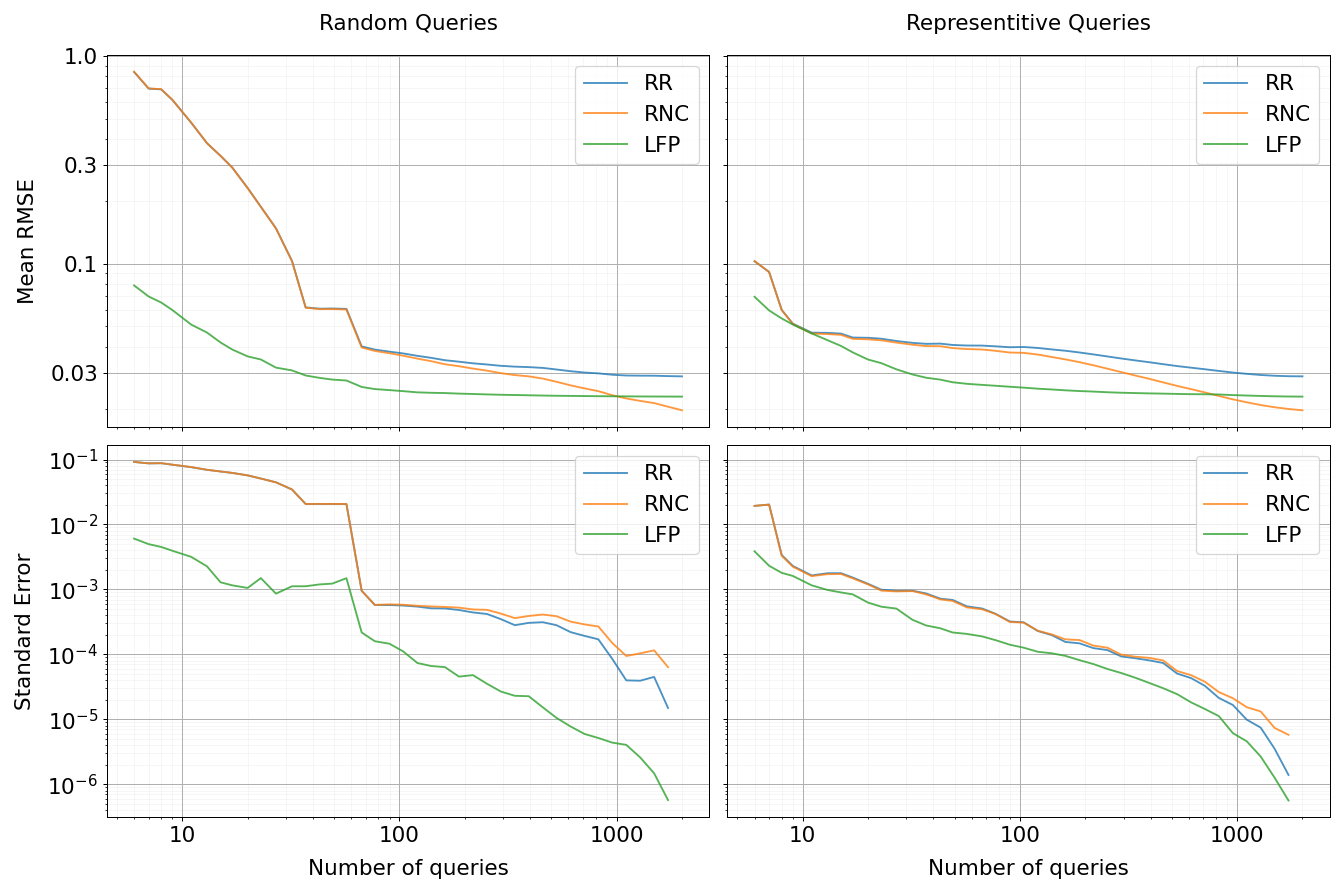

/tmp/ipykernel_10412/319830382.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{x:.0f}' for x in ax.get_xticks()], fontsize='xx-large')
/tmp/ipykernel_10412/319830382.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{x:.0f}' for x in ax.get_xticks()], fontsize='xx-large')
/tmp/ipykernel_10412/319830382.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{x:.0f}' for x in ax.get_xticks()], fontsize='xx-large')
/tmp/ipykernel_10412/319830382.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{x:.0f}' for x in ax.get_xticks()], fontsize='xx-large')
/tmp/ipykernel_10412/3355848000.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_yticklabels(['$10^{' + f'{int(np.log10(i))}' + '}$' for i in axes[1, 0].get_yticks()], fontsi

In [744]:
experiment_1(rmse_RR_passive7, rmse_RNC_passive7, rmse_LFP_passive7, rmse_RR_active7, rmse_RNC_active7, rmse_LFP_active7)


<IPython.core.display.Javascript object>


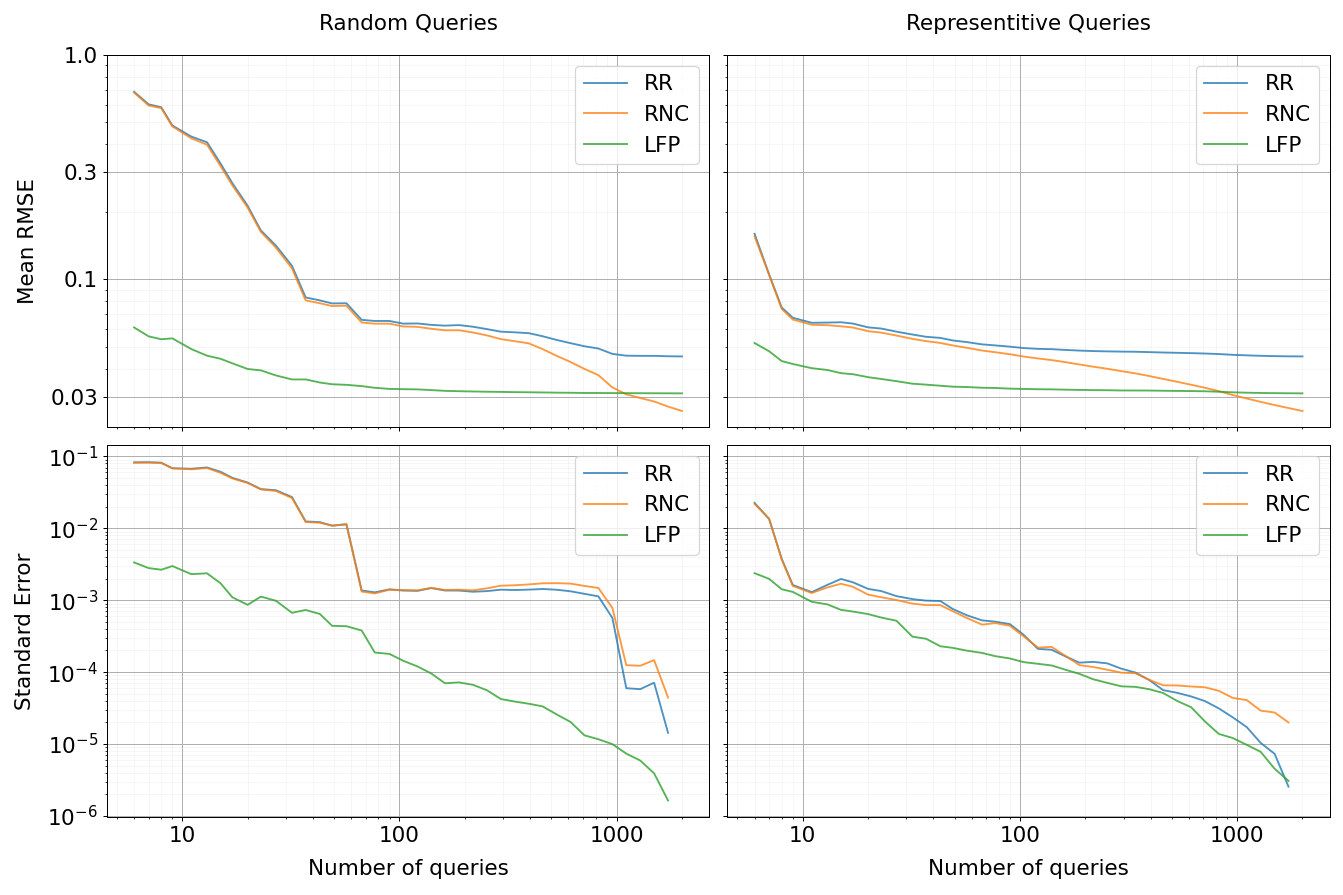

/tmp/ipykernel_10412/319830382.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{x:.0f}' for x in ax.get_xticks()], fontsize='xx-large')
/tmp/ipykernel_10412/319830382.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{x:.0f}' for x in ax.get_xticks()], fontsize='xx-large')
/tmp/ipykernel_10412/319830382.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{x:.0f}' for x in ax.get_xticks()], fontsize='xx-large')
/tmp/ipykernel_10412/319830382.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{x:.0f}' for x in ax.get_xticks()], fontsize='xx-large')
/tmp/ipykernel_10412/3355848000.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_yticklabels(['$10^{' + f'{int(np.log10(i))}' + '}$' for i in axes[1, 0].get_yticks()], fontsi

In [614]:
experiment_1(rmse_RR_passive6, rmse_RNC_passive6, rmse_LFP_passive6, rmse_RR_active6, rmse_RNC_active6, rmse_LFP_active6)

plt.savefig('queries.pdf')

In [587]:
def plot_mean_rmse(rmse_RR, rmse_RNC, rmse_LFP, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots()
        ax.set_ylabel('Mean RMSE', fontsize='xx-large', labelpad=10)

    x = nqs
    for y, label in zip([rmse_RR, rmse_RNC, rmse_LFP], ['RR', 'RNC', 'LFP']):

        y = np.array([np.mean(group) for group in y])
        ax.plot(x, y, label=label, alpha=0.8)
        
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.set_yticks([0.03, 0.1, 0.3, 1])
    ax.set_yticklabels([f'{x}' for x in ax.get_yticks()])
    
    ax.grid(which='major')
    ax.grid(which='minor', alpha=0.1)
    ax.legend(fontsize='xx-large')
    ax.set_xticklabels([f'{x:.0f}' for x in ax.get_xticks()], fontsize='xx-large')

    
def plot_std_rmse(rmse_RR, rmse_RNC, rmse_LFP, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots()

    x = nqs

    for y, label in zip([rmse_RR, rmse_RNC, rmse_LFP], ['RR', 'RNC', 'LFP']):

        y = np.array([np.std(group) / len(group) ** 0.5 for group in y])
        ax.plot(x[:-1], y[:-1], label=label, alpha=0.8) 
        
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.grid(which='major')
    ax.grid(which='minor', alpha=0.1)
    ax.legend(fontsize='xx-large')
    ax.set_xticklabels([f'{x:.0f}' for x in ax.get_xticks()], fontsize='xx-large')

In [603]:
def experiment_1(rmse_RR_passive, rmse_RNC_passive, rmse_LFP_passive, rmse_RR_active, rmse_RNC_active, rmse_LFP_active):

    fig, axes = plt.subplots(ncols=2, nrows=2, sharey='row', sharex=True, figsize=(15, 10))

    plot_mean_rmse(rmse_RR_passive, rmse_RNC_passive, rmse_LFP_passive, ax=axes[0, 0] )
    plot_mean_rmse(rmse_RR_active, rmse_RNC_active, rmse_LFP_active, ax=axes[0, 1])

    
    plot_std_rmse(rmse_RR_passive, rmse_RNC_passive, rmse_LFP_passive, ax=axes[1, 0] )
    plot_std_rmse(rmse_RR_active, rmse_RNC_active, rmse_LFP_active, ax=axes[1, 1])

    axes[0, 0].set_title('Random Queries', fontsize='xx-large', pad=20)
    axes[0, 1].set_title('Representitive Queries', fontsize='xx-large', pad=20)

    axes[0, 0].set_ylabel('Mean RMSE', fontsize='xx-large', labelpad=10)
    axes[1, 0].set_ylabel('Standard Error', fontsize='xx-large', labelpad=10)

    axes[1, 0].set_xlabel('Number of queries', fontsize='xx-large', labelpad=10)
    axes[1, 1].set_xlabel('Number of queries', fontsize='xx-large', labelpad=10)


    axes[0, 0].set_yticklabels([str(i) for i in axes[0, 0].get_yticks()], fontsize='xx-large')
    axes[1, 0].set_yticklabels(['$10^{' + f'{int(np.log10(i))}' + '}$' for i in axes[1, 0].get_yticks()], fontsize='xx-large')

    
    plt.tight_layout()
    
    # plt.savefig('queries.pdf')
    


In [647]:
['inverse', 'exponential', 'ReLu', 'sigmoid', 'cosine', 'cut-off']

['inverse', 'exponential', 'ReLu', 'sigmoid', 'cosine', 'cut-off']

In [682]:
betas = {'inverse': 10, 'exponential': 1.5, 'ReLu': 0.8, 'sigmoid': 1.5, 'cosine': 45, 'cut-off': 1.5}

In [746]:
beta

1.5

In [785]:
# EXPERIMENT 2: how does performance vary with different graph topologies

Omegas = []
Omega_RRs = []
Omega_RNCs = []
Omega_LFPs = []

for i, filter_func in enumerate([ 'cosine', 'cut-off']):
    
    params = get_params(T=50, N=40, function=filter_func, gamma=1e-1, random_graph=False, seed=True)

    filter_f, T, N, P, gamma, beta, eta, Y, S, S_, lamLT, lamLN, H, UT, UN, AT, AN, LT, LN, K, lamK, V, J, G, Lam, q, Q, X = params
    
    Omega = estimate_omega_cgm()
    
    Q = select_Q_active(n=100)
    Omega_Q = np.zeros_like(J)
    Omega_Q[Q.astype(bool)] = Omega[Q.astype(bool)]

    Omega_RR = estimate_omega_RR(Omega_Q, Q, lam=0.005)
    Omega_RNC = estimate_omega_RNC(Omega_Q, Q, verbose=False, lam=0.005)
    Omega_LFP = estimate_omega_LFP(Omega_Q, Q, lam=0.001)
    
    print(filter_func)
    
    print(f'RR: {rmse(Omega, Omega_RR):.4f}')
    print(f'RNC: {rmse(Omega, Omega_RNC):.4f}')
    print(f'LFP: {rmse(Omega, Omega_LFP):.4f}')
    print(beta)

    Omegas.append(Omega)
    Omega_RRs.append(Omega_RR)
    Omega_RNCs.append(Omega_RNC)
    Omega_LFPs.append(Omega_LFP)
    
    


  0%|          | 0/40 [00:00<?, ?it/s]

[ 0  0 45  0 45]
[ 0.4549  1.5413 36.0431 -0.7774  6.6256]
cosine
RR: 0.0801
RNC: 0.0730
LFP: 0.0769
45


  0%|          | 0/40 [00:00<?, ?it/s]

[0.  0.  1.5 0.  1.5]
[ 0.781   1.411   1.2591 -0.7266  2.6449]
cut-off
RR: 0.1408
RNC: 0.1306
LFP: 0.1660
1.5


<IPython.core.display.Javascript object>


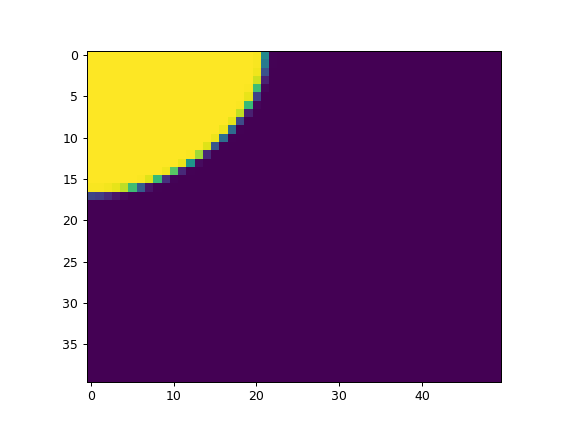

In [789]:
plt.figure()

plt.imshow(filter_functions['cut-off'](Lam, 1.5))

<IPython.core.display.Javascript object>


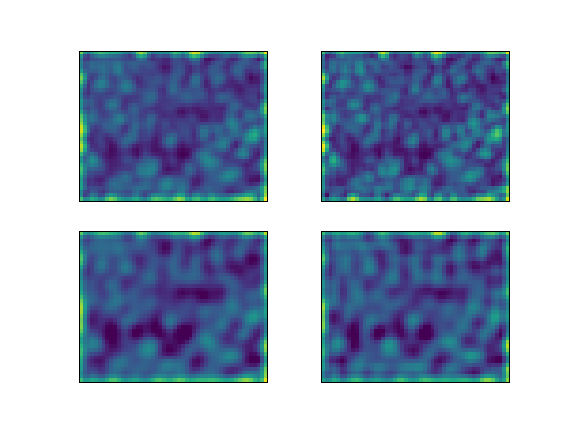

In [787]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)

axes[0, 0].imshow(Omegas[0])
axes[0, 1].imshow(Omegas[1])

axes[1, 0].imshow(Omega_LFPs[0], vmin=Omegas[0].min(), vmax=Omegas[0].max())
axes[1, 1].imshow(Omega_LFPs[1], vmin=Omegas[1].min(), vmax=Omegas[1].max())

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])    

<IPython.core.display.Javascript object>


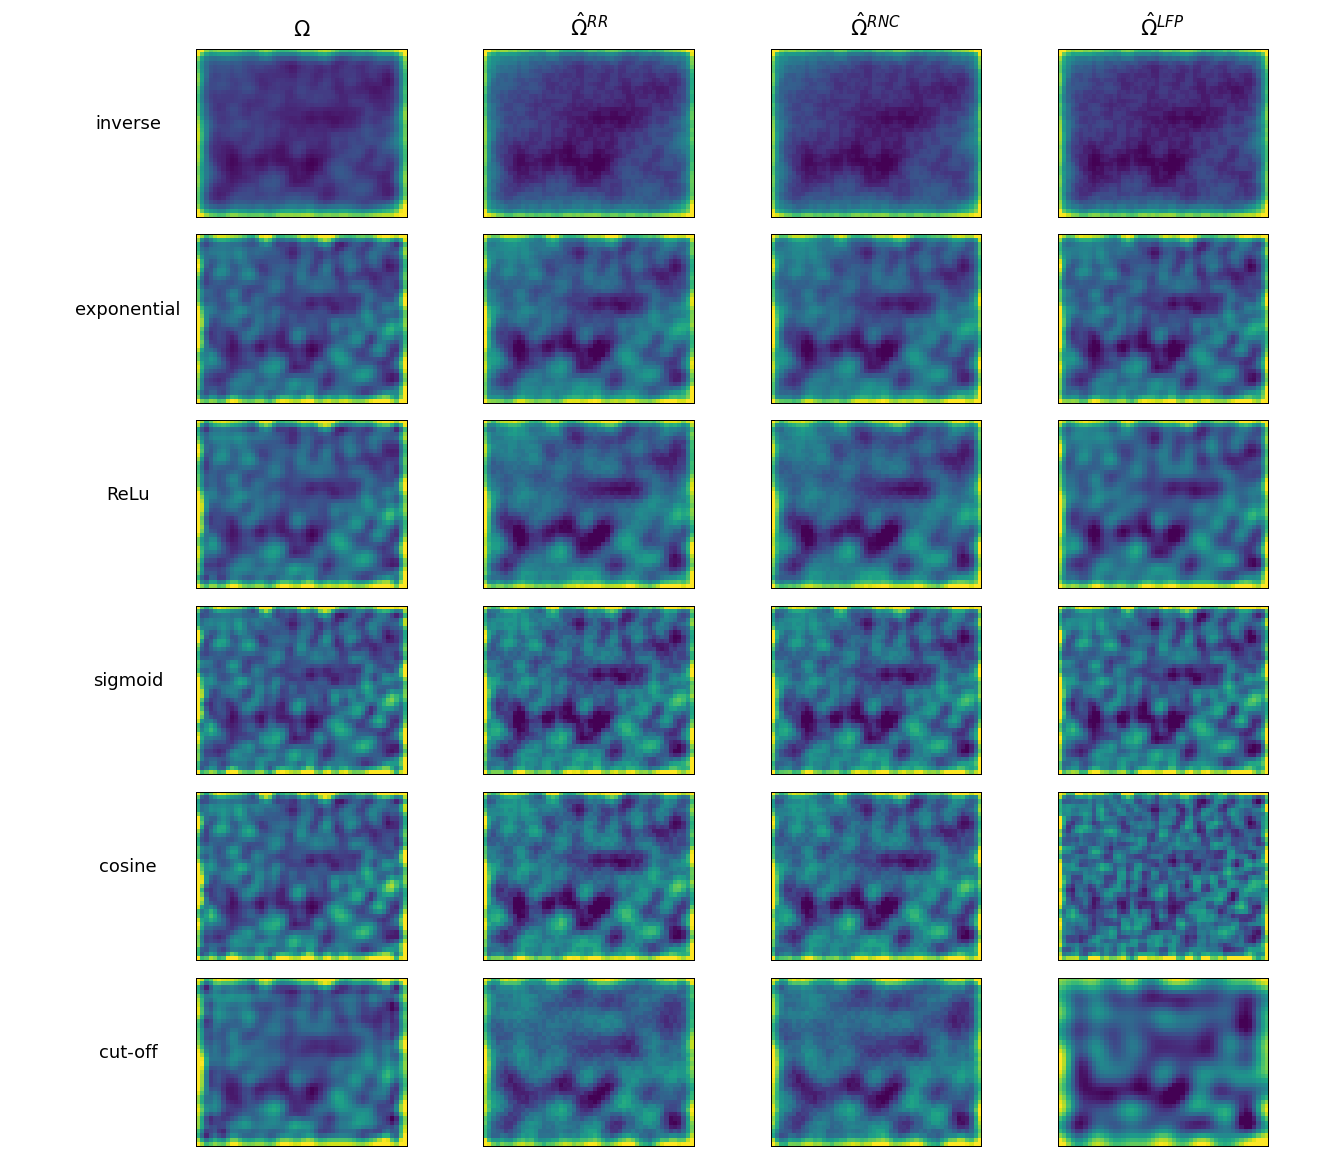

In [747]:
fig, axes = plt.subplots(ncols=4, nrows=6, sharex=True, sharey=True, figsize=(15, 13))

errors = [[], [], [], [], [], []]


for i, filter_func in enumerate(['inverse', 'exponential', 'ReLu', 'sigmoid', 'cosine', 'cut-off']):
    
    vmin=Omegas[i].min()
    vmax=Omegas[i].max() 

    vspread = vmax - vmin
    vmean = vmin + vspread / 2
    vmax = vmean + vspread * 0.2
#     vmin = vmean - vspread * 0.8
    
    axes[i, 0].imshow(Omegas[i], vmin=vmin, vmax=vmax)
    axes[i, 1].imshow(Omega_RRs[i], vmin=vmin, vmax=vmax)
    axes[i, 2].imshow(Omega_RNCs[i], vmin=vmin, vmax=vmax)
    axes[i, 3].imshow(Omega_LFPs[i], vmin=vmin, vmax=vmax)
    
    errors[i].append(rmse(Omegas[i], Omega_RRs[i]))
    errors[i].append(rmse(Omegas[i], Omega_RNCs[i]))
    errors[i].append(rmse(Omegas[i], Omega_LFPs[i]))

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

for ax, title in zip(axes[0, :], [r'${\Omega}$', r'$\hat{\Omega}^{{RR}}$', r'$\hat{\Omega}^{{RNC}}$', r'$\hat{\Omega}^{{LFP}}$']):
    ax.set_title(title, size='xx-large', pad=10) 

for ax, title in zip(axes[:, 0], ['inverse', 'exponential', 'ReLu', 'sigmoid', 'cosine', 'cut-off']):
    ax.set_ylabel(title, rotation=0, size='x-large', labelpad=55)
    
plt.tight_layout()
plt.subplots_adjust(left=0.1)

plt.savefig('filters.pdf')

In [690]:
errors = np.array(errors)
errors

array([[0.0649, 0.064 , 0.031 ],
       [0.0639, 0.0628, 0.0346],
       [0.086 , 0.0874, 0.0437],
       [0.0645, 0.0643, 0.0419],
       [0.0803, 0.082 , 0.1057],
       [0.1168, 0.113 , 0.1561]])

In [414]:
# EXPERIMENT 3: how does performance vary with gamma

In [457]:
params = get_params(T=50, N=40, function='exponential', gamma=1e-1, random_graph=False, seed=True)

filter_f, T, N, P, gamma, beta, eta, Y, S, S_, lamLT, lamLN, H, Hi, UT, UN, AT, AN, LT, LN, K, lamK, V, J, G, Lam, q, Q, X = params


In [458]:

Omega = estimate_omega_cgm()


  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
Omega_RNC = estimate_omega_RNC(Omega_Q, lam)
Omega_LFP = estimate_omega_LFP()

In [459]:
Omega_RR = estimate_omega_RR(Omega_Q, lam)


In [460]:
Omega_RR

array([[ 0.0877, -0.2279, -0.6864, ..., -0.2716, -0.1375,  0.5089],
       [-0.2435, -1.0247, -0.7628, ..., -1.0813, -1.0052, -0.528 ],
       [-0.7265, -1.1036, -1.1194, ..., -1.1803, -1.1166, -0.6911],
       ...,
       [-0.6817, -1.0867, -1.1241, ..., -0.6775, -0.5913, -0.1514],
       [-0.2429, -1.02  , -0.7394, ..., -0.6374, -0.8606, -0.0268],
       [ 0.0536, -0.5625, -0.3307, ..., -0.5953, -0.4344,  0.5843]])

In [461]:
Omega

array([[-0.9618, -1.4312, -1.6223, ..., -1.2632, -1.1008, -0.6866],
       [-1.4532, -1.9416, -2.0717, ..., -1.9145, -1.7895, -1.3109],
       [-1.684 , -2.0951, -2.1263, ..., -2.2931, -2.0902, -1.5702],
       ...,
       [-1.5648, -2.025 , -2.1115, ..., -1.8024, -1.5028, -1.0347],
       [-1.5284, -1.9897, -1.9467, ..., -1.8253, -1.5253, -0.9496],
       [-1.0989, -1.5191, -1.4934, ..., -1.542 , -1.2245, -0.6272]])

In [478]:
ax.set_title?